In [126]:
# previously recorded values from the reconnaissance run of dcraw
black = 2044
white = 16383
r_scale = 2.165039
g_scale = 1.0
b_scale = 1.643555

## python initials
here, we use skimage's imread to get read the image and obtain values

In [127]:
import numpy as np
from skimage.io import imread

image = imread("../../../data/Thayer.tiff").astype(np.float32)
print("height, width:", image.shape, "as type", image.dtype)
print("bits per pixel:", image.itemsize * 8)

height, width: (4016, 6020) as type float32
bits per pixel: 32


we can then convert this image into a double-precision array

In [128]:
image = image.astype(np.float64)
print("bits per pixel:", image.itemsize * 8)

bits per pixel: 64


## linearization
we can apply a linear transformation to the image so that the value \<black> is mapped to 0, and the value \<white> is mapped to 1. we then clip the negative values to 0, and values greater than 1 to 1

In [129]:
print("original min/max value:", image.min(), image.max())

image = (image - (black)) / (white - black)     # shift min to 0
print("post transformation min/max value:", image.min(), image.max())

image = np.clip(image, 0, 1)  # clip to [0, 1]
print("post clip min/max value:", image.min(), image.max())

original min/max value: 255.0 15305.0
post transformation min/max value: -0.12476462793779204 0.9248204198340191
post clip min/max value: 0.0 0.9248204198340191


## identifying the correct bayer pattern
we can begin by choosing a random bayer pattern to test for, beginning with rggb

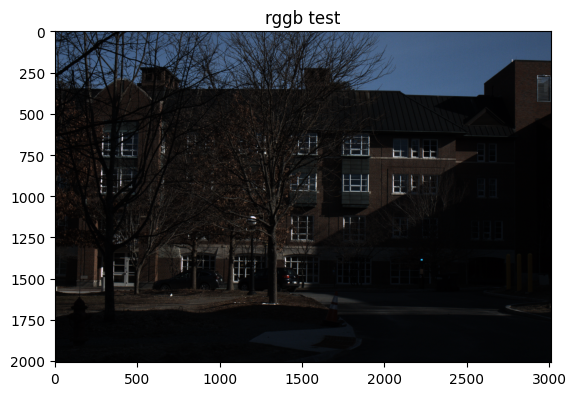

In [ ]:
import matplotlib.pyplot as plt

# 1. guessing a standard rggb
red = image[0::2, 0::2]
green1 = image[0::2, 1::2]
green2 = image[1::2, 0::2]
blue = image[1::2, 1::2]
# this is where red is top left, green1 is top right,
# green2 is bottom left, blue is bottom right

# averaging green
green = (green1 + green2) / 2

# white balancing
red = red * r_scale
green = green * g_scale
blue = blue * b_scale

# using dstack and clip to create the image
rgb_test_image = np.dstack((red, green, blue))
rgb_test_image = np.clip(rgb_test_image, 0, 1)

# 5. displaying
plt.imshow(rgb_test_image)
plt.title("rggb test")
plt.show()

we can observe that our rggb guess works perfectly. experimentally attempting with bggr, rgbg, etc. results in inaccurate color representation. we may perhaps want to come back to this and attempt this in an algorithmic manner by observing the top-leftmost 2x2 square of pixels and evaluating the weight of each channel there.

## white balancing
now that we have identified the correct bayer pattern, we can perform white balancing.